# Credit Risk Scoring Project

In this project we will solve a *binary classification* problem of default prediction. Were we'll predict whether or not a customer will fail to pay back a loan. Instead of using all the predictive machine learning models like we did in the other projects we will be focusing on the tree-based models. These are, Decision trees, Random Forest and XGBoost. There are other tree-based models we should look at but for the purpose of learning how tree-based models work these three should be enough.

## Problem Definition

Imagine that we work at a bank or a credited money lender. When we receive a loan application, we need to make sure that if we give the money, the customer will be able to pay it back. Every application
carries a risk of *default*, which is the failure to return the money.

We’d like to minimize this risk: before agreeing to give a loan, we want to score the customer and assess the chances of default. If it’s too high, we reject the application. This process is called “credit risk scoring.”

Machine learning can be used for calculating the risk. For that, we use a dataset with loans, where for each application, we know whether or not it was paid back successfully. Using this data, we can build a model for predicting the probability of default, and we can use this model to assess the risk of future borrowers not repaying the money.

In this project, we use machine learning to calculate the risk of default. The plan for the project is the following: 
* First, we load the data and do some initial preprocessing.
* Next, we train a decision tree model from Scikit-learn for predicting the probability
of default.
* After that, we tune the parameters of the model in order to get the best performance.
* Then we combine multiple decision trees into one model — a random forest. We
look at its parameters and tune them to achieve the best predictive performance.
* Finally, we explore a different way of combining decision trees — gradient boosting. We use XGBoost, a highly efficient library that implements gradient boosting. We’ll train a model and tune its parameters.

Credit risk scoring is a binary classification problem: the target is positive (“1”) if the customer defaults and negative (“0”) otherwise. For evaluating our solution, we’ll use AUC (area under the ROC curve). AUC describes how well our model can separate the cases into positive and negative ones.

## Load Dataset
We use a dataset from a data mining course at the [Polytechnic University
of Catalonia](https://www.cs.upc.edu/~belanche/Docencia/mineria/mineria.html). The dataset describes the customers (seniority, age, marital status, income, and other characteristics), the loan (the requested amount, the price of the item), and its status (paid back or not).

We use a copy of this dataset available on GitHub at https://github.com/gastonstat/CreditScoring/, we already have it here on this repository.

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
plt.style.use('ggplot')
%matplotlib inline

# load dataset
df = pd.read_csv('CreditScoring.csv')

## Data cleaning

Now that we have loaded the data, let's take a closer look at it and see if we need to do any preprocessing before we can use it. We need to look for for any issues in the data and fix them.

In [2]:
# head
df.head(10)

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910
5,1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
6,1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
7,1,9,5,12,27,1,1,1,35,80,0,0,200,1093
8,1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957
9,2,0,5,48,41,2,1,2,90,80,0,0,1200,1468


We see that all the column names start with a capital letter. Let's lowercase them. Then look at the shape of the dataset.

In [3]:
# cleaning column names
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:
# shape
df.shape

(4455, 14)

We can see that the DataFrame has 4455 features and 14 columns with the following description:
* status: whether the customer managed to pay back the loan (1) or not (2)
* seniority: job experience in years
* home: type of home ownership: renting (1), a homeowner (2), and others
* time: period planned for the loan (in months)
* age: age of the client
* marital [status]: single (1), married (2), and others
* records: whether the client has any previous records: no (1), yes (2) (It’s not
clear from the dataset description what kind of records we have in this column.
For the purposes of this project, we may assume that it’s about records in the
bank’s database.)
* job: type of job: full-time (1), part-time (2), and others
* expenses: how much the client spends per month
* income: how much the client earns per month
* assets: total worth of all the assets of the client
* debt: amount of credit debt
* amount: requested amount of the loan
* price: price of an item the client wants to buy

Even though most of the columns are numerical, some are categorical: status, home, marital [status], records, and job. The values we see in the DataFrame, however, are numbers, not strings. This means that we need to translate them to their actual names. We start with the status column. The value “1” means “OK,” the value “2” means “default,” and “0” means that the value is missing — let’s replace it with “unk”, which is short for “unknown”.

In [5]:
# converting status
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
} # dictionary needed for mapping

# maping the dictionary
df.status = df.status.map(status_values) # map function converts numbers to strings
df.head(10)

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,1,60,30,2,1,3,73,129,0,0,800,846
1,ok,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,default,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,ok,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,ok,0,1,36,26,1,1,1,46,107,0,0,310,910
5,ok,1,2,60,36,2,1,1,75,214,3500,0,650,1645
6,ok,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
7,ok,9,5,12,27,1,1,1,35,80,0,0,200,1093
8,ok,0,2,60,32,2,1,3,90,107,15000,0,1200,1957
9,default,0,5,48,41,2,1,2,90,80,0,0,1200,1468


Now we repeat the same procedure for all the other columns.

In [6]:
# converting the rest of the categorical columns
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

# head
df.head(10)

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910
5,ok,1,owner,60,36,married,no,fixed,75,214,3500,0,650,1645
6,ok,29,owner,60,44,married,no,fixed,75,125,10000,0,1600,1800
7,ok,9,parents,12,27,single,no,fixed,35,80,0,0,200,1093
8,ok,0,owner,60,32,married,no,freelance,90,107,15000,0,1200,1957
9,default,0,parents,48,41,married,no,partime,90,80,0,0,1200,1468


#### Descriptive Statistics
In the next steps we'll take a closer look at the numerical columns. Let's start by looking at the summary statistics.

In [7]:
# descriptions
df.describe().round() # we round to remove scientific notation

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


We notice immediately that the max value is 99999999 in some cases. This is quite suspicious. As it turns out, it’s an artificial value — this is how missing values are encoded in this dataset. 

Three columns have this problem: income, assets, and debt. Let’s replace this big
number with *NaN* for these columns:

In [8]:
for col in ['income', 'assets', 'debt']:
    df[col] = df[col].replace(to_replace=99999999, value=np.nan)

df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


After this transformation, in the summary no more suspicious numbers.

Let's have a look at our target feature before continuing with our data preparation.

In [9]:
# target distribution
df.status.value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

We notice that there’s one row with “unknown” status: we don’t know whether or not this client managed to pay back the loan. For our project, this row is not useful, so let’s filter it out from the dataset:

<AxesSubplot:xlabel='status', ylabel='count'>

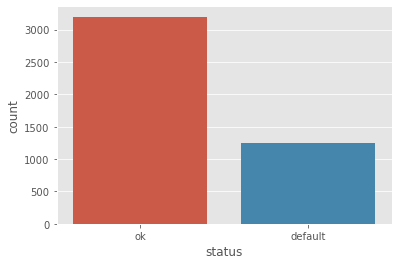

In [10]:
# remove unwanted target
df = df[df['status'] != 'unk']

sns.countplot(x='status', data=df)

In [11]:
# missing values
df.isnull().sum()

status        0
seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       34
assets       47
debt         18
amount        0
price         0
dtype: int64

We didn't really "remove" the record of the "unknown", we just created a new Dataframe without it. We will handle missing values later.

So far by looking at the data, we have identified and addressed a few important issues in the data.

### Unimodal Data Visualisations
Let's look at visualisations of individual features. It is often useful to look at your data using multiple different visualisations in order to spark ideas. Let's look at histograms of each feature to get a sense of the data distributions.

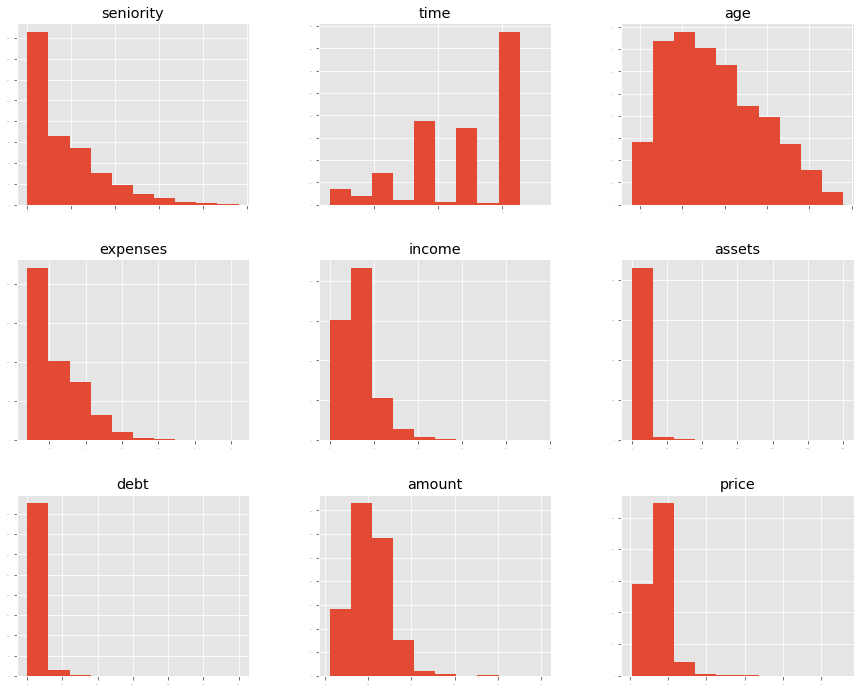

In [12]:
# histograms
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(15,12))
plt.show()

We can see that there features perhaps exponential-like distributions for other features.

Let's take a look at the same perspective of the data using density plots.

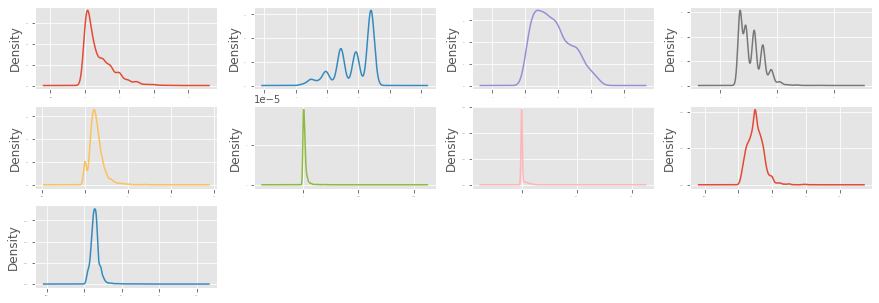

In [13]:
# Univariate Density Plots
df.plot(kind='density', subplots=True, layout=(4,4), figsize=(15,7), sharex=False, legend=False, fontsize=1)
plt.show()

This is useful, this confirms that many of the features have a skewed distribution..

It is always good to look at box and whisker plots of numeric features to get an idea of the spread of values.

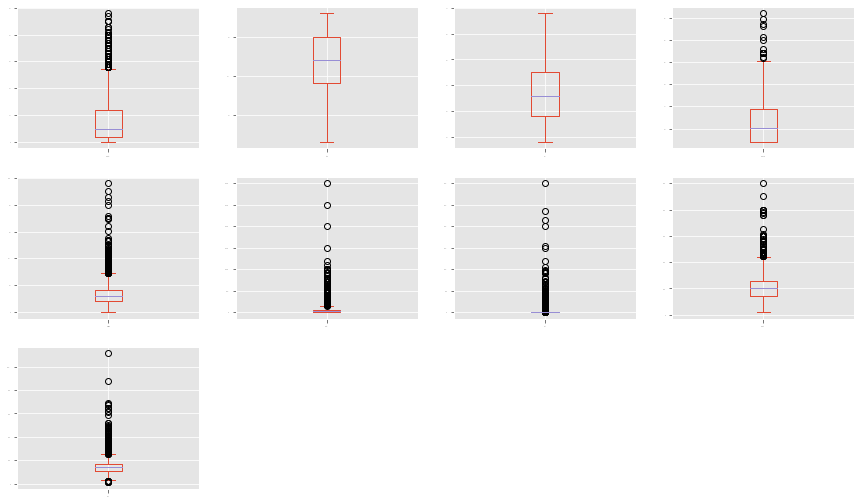

In [14]:
# Univariate box and whisker plots
df.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, fontsize=1, figsize=(15,12))
plt.show()

We can see that features do have quite different spreads.

### Multimodal Data Visualizations
Let's visualise the correlations between the features.

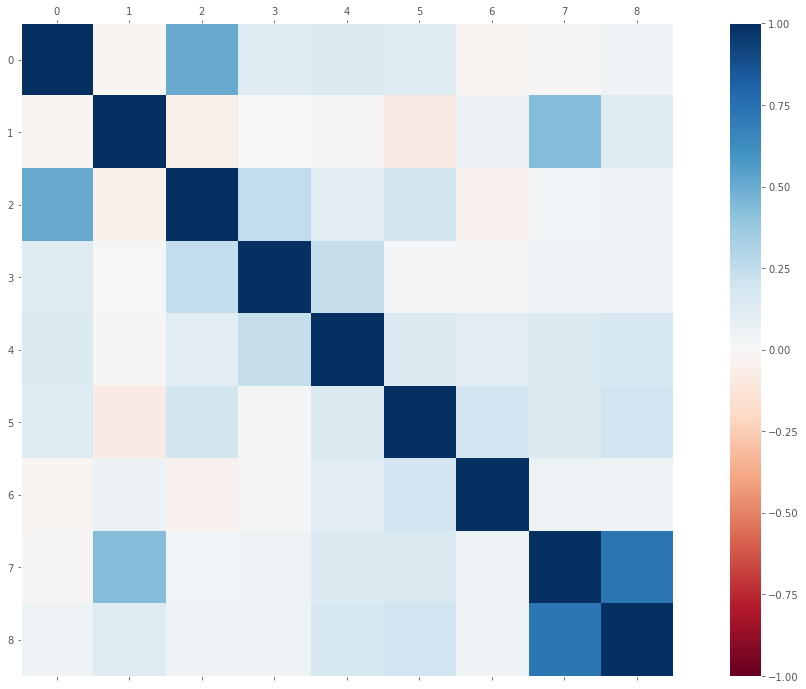

In [15]:
# Correction Matrix Plot
plt.rcParams['axes.grid'] = False 
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)
cax = ax.matshow(df.corr(), vmin=-1, vmax=1, interpolation='none', cmap='RdBu')
fig.colorbar(cax)
plt.show()

The dark blue color shows positive correlation whereas the dark red color shows negative correlation. As we cannot see some dark red and we see a bit of dark blue that suggest candidates for removal to better improve accuracy of models later on.

## Validation Dataset
Now that our dataset is cleaned, and we’re almost ready to use it for model training.
Before we can do that, we need to do a few more steps:
* Split the dataset into train, validation, and test.
* Handle missing values.
* Use one-hot encoding to encode categorical variables.
* Create the feature matrix X and the target variable y.

Let’s split the data. We will split the data into three parts:
* Training data (60% of the original dataset)
* Validation data (20%)
* Test data (20%)

In [16]:
# Split-out validation dataset
from sklearn.model_selection import train_test_split # import a library for splitting the dataset
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

When splitting for the second time, we put aside 25% of data instead of 20% (test_size=0.25). Because df_train_full contains 80% of records, one-quarter (as in, 25%) of 80% corresponds to 20% of the original dataset.

Let's check the size of our datasets using the len function:

In [17]:
# length of datasets
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

So, for training, we will use approximately 2,700 examples and almost 900 for validation and testing.

Our target variable is *y* and we will use it to train our models. Because our objective is to determine if somebody fails to payback their loan, the positive class is *default*. This means that *y* is "1" if the client defaulted and "0" otherwise. 

In [18]:
y_train = (df_train.status == 'default').values
y_val = (df_val.status == 'default').values

We'll now remove the *status* feature from the DataFrames. We don't want to accidentally use it for training.

In [19]:
# delete status
del df_train['status']
del df_val['status']

Let's take care of the missing values in order to fully prepare our feature matrix *X*. We'll replace the missing values with zero:

In [20]:
# fill missing
df_train = df_train.fillna(0)
df_val = df_val.fillna(0)

We're now going to handle categorical variables, to do so we'll encode them with one-hot encoding. In one-hot encoding, each value is encoded as “1” if it’s present (“hot”) or “0” if it’s absent (“cold”). To implement it, we use *Dict-Vectorizer* from Scikit-learn.

In [21]:
# one-hot encode
from sklearn.feature_extraction import DictVectorizer
dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')

dict_train[0]

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

Each dictionary in the result represents a row from the DataFrame. For example, the first record in dict_train looks like dict_train[0].

This list of dictionaries now can be used as input to *DictVectorizer*:

In [22]:
# OHE
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

We now have the feature matrix for both the train and validation datasets.

Now we're ready to train a model. We'll start with the decision tree model.

## Evaluate Algorithms: Decision trees
A *decision tree* is a data structure that encodes a series of if-then-else rules. Each node in a tree contains a condition. If the condition is satisfied, we go to the right side of the
tree; otherwise, we go to the left. In the end we arrive at the final decision.

We'll use scikit-learn for training a decision tree.

In [23]:
# training the model
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

We need to evaluate the predictive performance of the
model on the validation set to check if the results is good. Let’s use AUC (area under the ROC curve) for that. AUC shows how well a model separates positive examples from negative examples. It
has a nice interpretation: it describes the probability that a randomly chosen positive example (“default”) has a higher score than a randomly chosen negative example (“OK”). This is a relevant metric for this project: we want risky clients to have higher
scores than non-risky ones.

Because we chose AUC as the evaluation metric, we need scores, not hard predictions. For this, we'll use the *predict_proba* method.

In [24]:
# load library
from sklearn.metrics import roc_auc_score
y_pred = dt.predict_proba(X_train)[:, 1] 
roc_auc_score(y_train, y_pred)

1.0

We get a perfect score of 100%. Does it mean that we can predict default without errors? Let's verify on the validation dataset without jumping to conclusions.

In [25]:
# validation
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6594384974934006

The AUC score on validation is only 67%. This is a case of *overfitting*. The tree learned the training data so well that it simply memorized the outcome for each customer. However, when we applied it to the validation set, the model failed. The rules it extracted from the data turned out to be too specific to the training set, so it worked poorly for customers it didn’t see during training. In such cases, we say that the model cannot *generalise*.

Overfitting happens when we have a complex model with enough power to remember all the training data. If we force the model to be much simpler, we can make it less powerful and improve the model’s ability to generalise.

Let's restrict the size of the tree by specifying the *max_depth* parameter, which controls the maximum number of levels. The more levels a tree has, the more complex the rules it can learn.

The default parameter for the *max_depth* parameter is *None*, which means that the tree can grow as large as possible. Let's try a smaller value and compare the results.

In [26]:
# training with less depth
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train auc', auc)
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('validation auc', auc)

train auc 0.7054989859726213
validation auc 0.6685264343319367


We see that the score dropped. Previously, the training score was 100% and now it's only 70.5%. It means that the model can no longer memorise all the outcomes from the training set. On the other hand, the score on the validation is slightly better, from 66.77% to 66.85%. By making the model less complex, we improved the ability of our model to generalise. Now it's better at predicting the outcomes for customers it hasn't seen previously.

In the next section we will tune the tree in order to make it better by different parameters.

### Tuning Decision tree
We're going to tune two parameters:
* max_depth
* min_leaf_size
These two are the most important ones, so we will adjust only them. You can check the other parameters in the official documentation (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

When we trained our model previously, we restricted the depth of the tree to 2, but we didn’t touch *min_leaf_size*. With this, we got an AUC of 67% on the validation set.
Let’s find the best parameters.
We start by tuning max_depth. For that, we iterate over a few reasonable values and see what works best:

In [27]:
# algorithm tuning
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.767
   6 -> 0.758
  10 -> 0.694
  15 -> 0.658
  20 -> 0.663
None -> 0.658


The value *None* means that the depth can increase without any restrictions. We see that the *max_depth* of 5 gives the best AUC of 76.7%, followed by 4 and 6.

Let's tune *min_leaf_size*. For this, we iterate over the three best parameters of *max_depth*, and for each go over different values of *min_leaf_size*:

In [28]:
# tune min_leaf_size
for d in [4, 5, 6]:
    print('depth: %s' % d)
    
    for l in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=l)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (l, auc))
    print()

depth: 4
1 -> 0.761
5 -> 0.761
10 -> 0.761
15 -> 0.764
20 -> 0.761
50 -> 0.753
100 -> 0.756
200 -> 0.747

depth: 5
1 -> 0.766
5 -> 0.768
10 -> 0.762
15 -> 0.773
20 -> 0.774
50 -> 0.768
100 -> 0.763
200 -> 0.759

depth: 6
1 -> 0.750
5 -> 0.762
10 -> 0.778
15 -> 0.785
20 -> 0.773
50 -> 0.772
100 -> 0.776
200 -> 0.768



We see that the best AUC is 78.5% with parameters min_sample_leaf=15 and max_depth=6. We note that the value we use for min_sample_leaf influences the best value of *max_depth*.

Let's use the best parameters that we have found to train the model.

In [29]:
# finalise model
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_dt)

0.7854738320699426

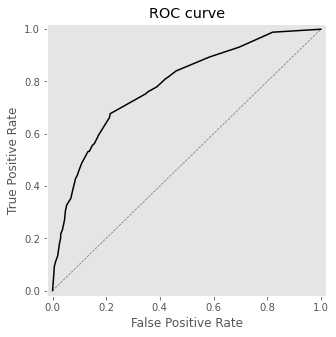

In [30]:
# plotting
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_val, y_pred_dt)

plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

The model achieved a score of 78.5%. We also plot the ROC curve which we will keep on comparing the AUC scores of the models we use and see the improvements done. The diagonal line is a baseline, we want our models roc curve to be further to the left of the baseline indicating a good model. In this case the roc curve of the Decision tree model achieves this. The ROC curves and AUC scores together they tell us how well the model separates the positive and negative examples.

Decision trees are simple and effective models, but they become even more powerful when we combine many trees together. In the next section, we’ll see how we can do it to achieve even better predictive performance.

# Random forest
In the past before machine learning algorithms existed to help us with credit risk scoring. There were a group of experts. Each expert can independently decide if a loan application should be approved or rejected. An individual expert may make a mistake. By contrast, it's less likely that all all experts put together decide to accept the application, but the customer fails to pay back the money.
Hence, all experts independently can be asked to and then combine their predictions into the final decision, for example, by majority vote.

This idea applies to machine learning and it's the idea behind the Random forest model. The concept is called *ensemble learning*. Ensemble learning, is a process whereby, one model individually may be wrong, but if we combine the output of multiple models into one, the chance of an incorrect prediction is smaller, a combination of models is called an *ensemble*. 

To train a random forest, we can do this:
* Train *N* independent decision tree models.
* For each model, select a random subset of features, and use only them for training.
* When predicting, combine the output of *N* models into one.

We can use Scikit-learn which contains an implementation of a random forest to solve our problem.

In [31]:
# training model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, random_state=3)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7811145285897654

To make the results consistent, we fix the random_state parameter. The AUC we got is 78%. 

The number of trees in an ensemble is an important parameter as it influences the performance of the model.
We will iterate over different values of *n_estimators* and see its effect on AUC:

In [32]:
# best estimator
aucs = [] # list of auc results

for i in range(10 ,201, 10):
    rf = RandomForestClassifier(n_estimators=i, random_state=3)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (i, auc))
    
    aucs.append(auc)

10 -> 0.781
20 -> 0.801
30 -> 0.813
40 -> 0.815
50 -> 0.816
60 -> 0.817
70 -> 0.818
80 -> 0.818
90 -> 0.820
100 -> 0.819
110 -> 0.819
120 -> 0.821
130 -> 0.822
140 -> 0.822
150 -> 0.820
160 -> 0.820
170 -> 0.819
180 -> 0.820
190 -> 0.820
200 -> 0.820


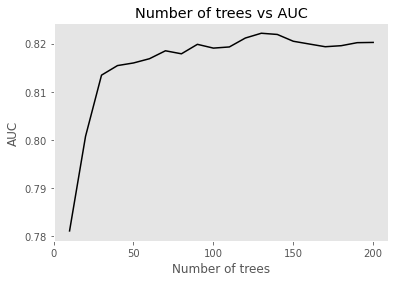

In [33]:
# plot of aucs
plt.figure(figsize=(6, 4))

plt.plot(range(10, 201, 10), aucs, color='black')
plt.xticks(range(0, 201, 50))

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

plt.show()

The performance grows rapidly for the first 25–30 trees; then the growth slows down. After 130, adding more trees is not helpful anymore: the performance stays approximately at the level of 82%. The number of trees is not the only parameter we can tweak for the best performance. In the next section we will tune more parameters.

### Tuning Random forest
A random forest ensemble consists of multiple decision trees, so the most important parameters we need to tune for random forest are the same:
* *max_depth*
* *min_leaf_size*

For other parameters to tweak please refer to the documentation for more information (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [34]:
# tuning max_depth
all_aucs = {}

for depth in [5, 10, 20]:
    print('depth: %s' % depth)
    aucs = []
    
    for i in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=i, max_depth=depth, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
        
    all_aucs[depth] = aucs
    print()
        

depth: 5
10 -> 0.788
20 -> 0.798
30 -> 0.800
40 -> 0.800
50 -> 0.800
60 -> 0.801
70 -> 0.802
80 -> 0.803
90 -> 0.804
100 -> 0.804
110 -> 0.807
120 -> 0.806
130 -> 0.808
140 -> 0.807
150 -> 0.807
160 -> 0.807
170 -> 0.807
180 -> 0.807
190 -> 0.807
200 -> 0.807

depth: 10
10 -> 0.791
20 -> 0.808
30 -> 0.812
40 -> 0.818
50 -> 0.817
60 -> 0.819
70 -> 0.820
80 -> 0.820
90 -> 0.820
100 -> 0.821
110 -> 0.823
120 -> 0.823
130 -> 0.825
140 -> 0.824
150 -> 0.824
160 -> 0.825
170 -> 0.825
180 -> 0.825
190 -> 0.825
200 -> 0.825

depth: 20
10 -> 0.776
20 -> 0.803
30 -> 0.813
40 -> 0.817
50 -> 0.815
60 -> 0.813
70 -> 0.814
80 -> 0.815
90 -> 0.814
100 -> 0.815
110 -> 0.817
120 -> 0.816
130 -> 0.818
140 -> 0.818
150 -> 0.818
160 -> 0.818
170 -> 0.817
180 -> 0.817
190 -> 0.817
200 -> 0.818



For each max_depth we have a series of AUC scores. We can plot them now:

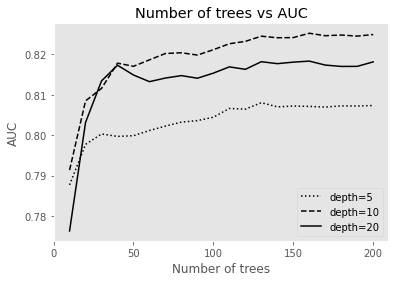

In [35]:
# plot of aucs
plt.figure(figsize=(6, 4))

num_trees = list(range(10, 201, 10))

plt.plot(num_trees, all_aucs[5], label='depth=5', color='black', linestyle='dotted')
plt.plot(num_trees, all_aucs[10], label='depth=10', color='black', linestyle='dashed')
plt.plot(num_trees, all_aucs[20], label='depth=20', color='black', linestyle='solid')
    
plt.xticks(range(0, 201, 50))
plt.legend()

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

plt.show()

With max_depth=10, AUC goes over 82%, whilst the other values perform worse.

Next, we'll tune *min_samples_leaf* where we set the value for the max_depth parameter to 10 and then follow the same the same approach as the last one.

In [36]:
# tuning min_samples_leaf
all_aucs = {}

for m in [3, 5, 10]:
    print('min_samples_leaf: %s' % m)
    aucs = []
    
    for i in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=i, max_depth=10, min_samples_leaf=m, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
        
    all_aucs[m] = aucs
    print()

min_samples_leaf: 3
10 -> 0.811
20 -> 0.820
30 -> 0.823
40 -> 0.822
50 -> 0.823
60 -> 0.823
70 -> 0.822
80 -> 0.823
90 -> 0.823
100 -> 0.823
110 -> 0.823
120 -> 0.825
130 -> 0.824
140 -> 0.825
150 -> 0.825
160 -> 0.826
170 -> 0.825
180 -> 0.825
190 -> 0.825
200 -> 0.825

min_samples_leaf: 5
10 -> 0.813
20 -> 0.815
30 -> 0.818
40 -> 0.820
50 -> 0.821
60 -> 0.823
70 -> 0.822
80 -> 0.823
90 -> 0.822
100 -> 0.824
110 -> 0.825
120 -> 0.825
130 -> 0.825
140 -> 0.824
150 -> 0.825
160 -> 0.825
170 -> 0.825
180 -> 0.825
190 -> 0.826
200 -> 0.825

min_samples_leaf: 10
10 -> 0.810
20 -> 0.818
30 -> 0.822
40 -> 0.822
50 -> 0.822
60 -> 0.822
70 -> 0.819
80 -> 0.820
90 -> 0.820
100 -> 0.819
110 -> 0.820
120 -> 0.820
130 -> 0.821
140 -> 0.820
150 -> 0.820
160 -> 0.820
170 -> 0.820
180 -> 0.820
190 -> 0.820
200 -> 0.820



For each min_samples_leaf we have a series of AUC scores. We can plot them now:

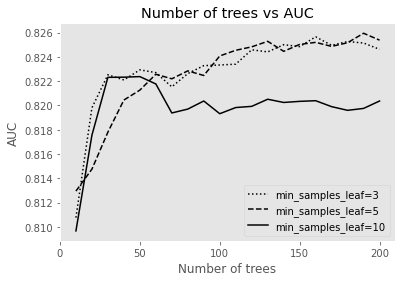

In [37]:
# plot of aucs
plt.figure(figsize=(6, 4))

num_trees = list(range(10, 201, 10))

plt.plot(num_trees, all_aucs[3], label='min_samples_leaf=3', color='black', linestyle='dotted')
plt.plot(num_trees, all_aucs[5], label='min_samples_leaf=5', color='black', linestyle='dashed')
plt.plot(num_trees, all_aucs[10], label='min_samples_leaf=10', color='black', linestyle='solid')
    
plt.xticks(range(0, 201, 50))
plt.legend()

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

plt.show()

The AUC is slightly better for small values of min_samples_leaf and the best value is 5.
Thus, the best parameters for random forest for our problem are
* max_depth=10
* min_samples_leaf=5
We'll set the n_estimator parameter to 200 as it's the number of trees we got the best AUC.

Let's train the final model.

In [38]:
# finalise model
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_rf)

0.8253826499721489

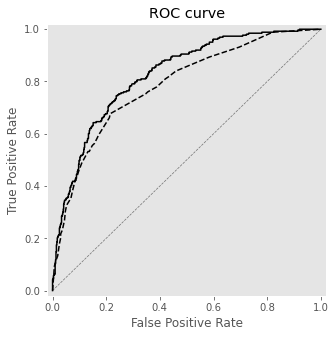

In [39]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred_rf)
plt.plot(fpr, tpr, color='black')

fpr, tpr, _ = roc_curve(y_val, y_pred_dt)
plt.plot(fpr, tpr, color='black', linestyle='dashed')

plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

The best the random forest model is able to get is 82.5% AUC, whereas decision trees got 78%. The ROC curve for random forest is showing an even better improvement than of decision tree.

In the next section we'll cover another method to combine multiple decision trees.

## Gradient boosting
The random forest method is not the only way to combine multiple models together in one ensemble. An alternative method is called *boosting*, where a model is trained sequentially, each next model tries to fix errors from the previous one:
* Train the first model.
* Look at the errors it makes.
* Train another model that fixes these errors.
* Look at the errors again; repeat sequentially.

*Gradient boosting* is a particular variation of this approach that works especially well with trees. We'll use it to solve our problem.

### XGBoost: Extreme gradient boosting
There are many good implementations of the gradient boosting model: *GradientBoostingClassifier* from Scikit-learn, XGBoost, LightGBM, CatBoost and AdaBoost. In this project we use *XGBoost* which is the most popular implementation. 

XGBoost doesn't come with Anaconda, so to use it, we install it with pip: *pip install xgboost*.

Before we can train an XGBoost model, we need to wrap our data into *DMatrix*, a special data structure for finding splits efficiently.

In [40]:
# loading xgboost
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

The next step is specifying the parameters for training. We’re using only a small subset of the default parameters of XGBoost (check the official documentation for the entire list of [parameters](https://xgboost.readthedocs.io/en/latest/parameter.html)):

In [41]:
# setting parameters
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1
}
# training the model
model = xgb.train(xgb_params, dtrain, num_boost_round=10)


[22:30:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Let's evaluate the model. Notice that the *objective* parameter from the xgb_params is set to 'binary:logistic'. As we're solving a binary classification problem.

In [42]:
# evaluation
y_pred = model.predict(dval)
y_pred[:10]

array([0.08926772, 0.0468099 , 0.09692743, 0.17261842, 0.05435968,
       0.12576081, 0.08033007, 0.61870354, 0.486538  , 0.04056795],
      dtype=float32)

The result, y_pred, is a one dimensional NumPy with predictions. Let's check the AUC score.

In [43]:
# AUC
roc_auc_score(y_val, y_pred)

0.8152745150274878

We get 81.5%. Which is slightly less than the random forest score of 82.5%. However, we might achieve a better score with tuning.

### Model performance monitoring
In order to get an idea of how AUC changes as the number of trees grows, we can use an built-in feature in XGBoost called watchlist for monitoring model performance.

This watchlist is a Python list with tuples. Each tuple contains a DMatrix and it's name. Additionally, we specify the metric we use for evaluation which in our case is AUC.

In [44]:
# monitor
watchlist = [(dtrain, 'train'), (dval, 'val')]

# modify
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

To use the watchlist during training, we need to specify two extra arguments for the train function:
* evals: the watchlist.
* verbose_eval: how often we print the metric. If we set it to “10,” we see the result after each 10th step.

Let's train the model.

In [45]:
# model training
model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=10)

[0]	train-auc:0.86300	val-auc:0.76818
[10]	train-auc:0.95002	val-auc:0.81558
[20]	train-auc:0.97316	val-auc:0.81775
[30]	train-auc:0.98772	val-auc:0.81788
[40]	train-auc:0.99456	val-auc:0.81387
[50]	train-auc:0.99688	val-auc:0.81128
[60]	train-auc:0.99889	val-auc:0.80801
[70]	train-auc:0.99944	val-auc:0.80732
[80]	train-auc:0.99985	val-auc:0.80677
[90]	train-auc:0.99991	val-auc:0.80637
[99]	train-auc:0.99997	val-auc:0.80546


As the number of trees grows, the score on the training set goes up. This is expected, as in boosting, every next model tries to fix the mistakes from
the previous step, so the score is always improving. For the validation score, this is not the case. It goes up initially then starts to decrease. This is an effect of overfitting. 

To capture the outputs, we can use
* %%capture instruction that saves the result to output
* parse_xgb_output function that parses it

In [46]:
%%capture output

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=5)

def parse_xgb_output(output):
    tree = []
    aucs_train = []
    aucs_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        tree.append(it)
        aucs_train.append(train)
        aucs_val.append(val)

    return tree, aucs_train, aucs_val


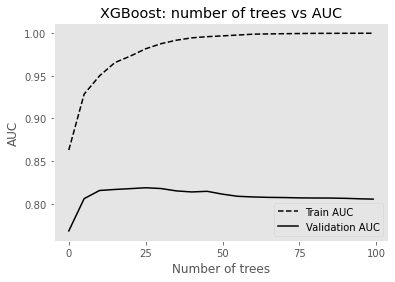

In [47]:
# plotting
tree, aucs_train, aucs_val = parse_xgb_output(output)
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_train, color='black', linestyle='dashed', label='Train AUC')
plt.plot(tree, aucs_val, color='black', linestyle='solid', label='Validation AUC')
plt.xticks(range(0, 101, 25))

plt.legend()

plt.title('XGBoost: number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

plt.show()


We get the best AUC on the 30th iteration (81.7%), but it’s not so different from the score we got on the 10th iteration (81.5%). To rectify this issue we'll tune the parameters of XGBoost in order to get the best out of it.

## Tuning XGBoost
We used a subset of the default parameters for training a model.

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

We're interested in the 1st three parameters as they control the training process:
* *eta*: Learning rate. Decision trees and random forest don’t have this parameter.
We cover it later in this section when we tune it.
* *max_depth*: The maximum allowed depth of each tree; the same as max_depth
in DecisionTreeClassifier from Scikit-learn.
* *min_child_weight*: The minimal number of observations in each group; the
same as min_leaf_size in DecisionTreeClassifier from Scikit-learn.

Other parameters are as we stated them before. We can learn more about all
the parameters in the official [documentation](https://xgboost.readthedocs.io/en/latest/parameter.html).

We'll start by tuning the *eta*, the learning rate. In boosting, the learning rate determines the weight of correction that each tree tries to to correct the mistakes from the previous iterations. If the rate is large, the correction overweighs the previous one significantly. However, if the rate is small, only a small fraction is used. In summary, it means:
* If eta is too large, the model starts to overfit quite early without realizing its full potential.
* If it’s too small, we need to train too many trees before it can produce good results.

#### Parameter tuning: eta
The default value of eta is 0.3, it's reasonably good for large datasets but small ones like ours, we will try smaller values like 0.1 and 0.05.

In [48]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [49]:
tree, _, aucs_val_eta_03 = parse_xgb_output(output)
print(max(aucs_val_eta_03))
print(max(zip(aucs_val_eta_03, tree)))

0.81788
(0.81788, 30)


In [50]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [51]:
tree, _, aucs_val_eta_01 = parse_xgb_output(output)
print(max(aucs_val_eta_01))
print(max(zip(aucs_val_eta_01, tree)))

0.82476
(0.82476, 70)


Because we're using smaller eta, 100 iterations is not enough. We use 500 iterations instead for training.

For eta at 0.3 the AUC score is 81.7% and for eta at 0.1 is 82.5%. Let's the two models.

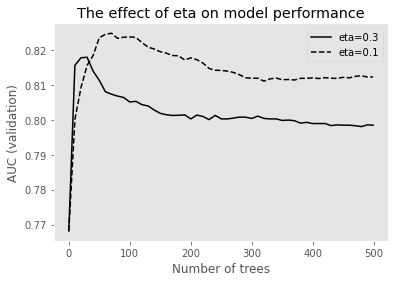

In [52]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_eta_03, color='black', linestyle='solid', label='eta=0.3')
plt.plot(tree, aucs_val_eta_01, color='black', linestyle='dashed', label='eta=0.1')
# plt.plot(tree, aucs_val_eta_005, color='grey', linestyle='solid', label='eta=0.05')
# plt.plot(tree, aucs_val_eta_001, color='grey', linestyle='dashed', label='eta=0.01')

plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('The effect of eta on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')


plt.show()

We see that for eta of 0.3, we get the AUC very quick compared to eta of 0.1. But then eta of 0.3 starts to overfit, after 30 iterations the performance on the validation set drops. For eta of 0.1, AUC grows slowly but peaks at high value. Let's look at more smaller eta values.

In [53]:
%%capture output

xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [54]:
tree, _, aucs_val_eta_005 = parse_xgb_output(output)
print(max(aucs_val_eta_005))
print(max(zip(aucs_val_eta_005, tree)))

0.82297
(0.82297, 120)


In [55]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [56]:
tree, _, aucs_val_eta_001 = parse_xgb_output(output)
print(max(aucs_val_eta_001))
print(max(zip(aucs_val_eta_001, tree)))

0.82168
(0.82168, 499)


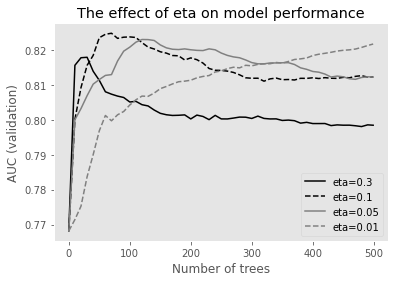

In [57]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_eta_03, color='black', linestyle='solid', label='eta=0.3')
plt.plot(tree, aucs_val_eta_01, color='black', linestyle='dashed', label='eta=0.1')
plt.plot(tree, aucs_val_eta_005, color='grey', linestyle='solid', label='eta=0.05')
plt.plot(tree, aucs_val_eta_001, color='grey', linestyle='dashed', label='eta=0.01')

plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('The effect of eta on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')


plt.show()

For comparison sake, the other values of eta we see that:
* For 0.05, the best AUC is 82.2% (after 120 iterations).
* For 0.01, the best AUC is 82.1% (after 500 iterations).

When eta is 0.05, the performance is similar to 0.1, but taking 60 more iterations to reach it's peak. For eta of 0.01, we experience slow growth, 
and even after 500 iterations, we haven't reached the peak. We see that trying more values of eta will become computationally expensive to evaluate all these trees during prediction time. Henceforth, we stick with the value of 0.1 for eta.

#### Tuning max_depth
We next tune the max_depth parameter. The default value is 6, so we can try
* A lower value; for example, 3
* A higher value; for example, 10.


In [58]:
%%capture output

# max_depth of 3

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [59]:
tree, _, aucs_val_depth3 = parse_xgb_output(output)
print(max(aucs_val_depth3))
print(max(zip(aucs_val_depth3, tree)))

0.83657
(0.83657, 180)


In [60]:
%%capture output

# max_depth of 10
xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [61]:
tree, _, aucs_val_depth10 = parse_xgb_output(output)
print(max(aucs_val))
print(max(zip(aucs_val_depth10, tree)))

0.81878
(0.81169, 100)


With depth=3 it's better than depth=6 and depth=10. So let's try 4 to see if it's better than 3.

In [62]:
%%capture output

# max_depth of 4

xgb_params = {
    'eta': 0.1,
    'max_depth': 4,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [63]:
tree, _, aucs_val_depth4 = parse_xgb_output(output)
print(max(aucs_val_depth4))
print(max(zip(aucs_val_depth4, tree)))

0.83014
(0.83014, 80)


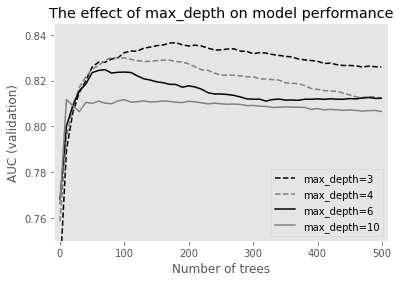

In [64]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_depth3, color='black', linestyle='dashed', label='max_depth=3')
plt.plot(tree, aucs_val_depth4, color='grey', linestyle='dashed', label='max_depth=4')
plt.plot(tree, aucs_val_eta_01, color='black', linestyle='solid', label='max_depth=6')
plt.plot(tree, aucs_val_depth10, color='grey', linestyle='solid', label='max_depth=10')

plt.ylim(0.75, 0.845)
plt.xlim(-10, 510)
plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('The effect of max_depth on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

plt.show()

We saw that the best AUC we got was 83.7% for max_depth of 3. For 10, we got 81.1%. This suggested that the best value be between 3 and 6. However when we tried for 4 we got 83% which was slightly worse than the value we got for max_depth of 3. 

#### Tune "min_child_weight"
The next value we tune is for *min_child_weight*. It’s the same as min_leaf_size in decision trees from Scikit-learn, it controls the minimal number of observations a tree can have in a leaf.

Let’s try a range of values and see which one works best. In addition to the default value (1), we can try 10 and 30

In [65]:
%%capture output

# min_child_weight of 1

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [66]:
tree, _, aucs_val_mcw1 = parse_xgb_output(output)
print(max(aucs_val_mcw1))
print(max(zip(aucs_val_mcw1, tree)))

0.83657
(0.83657, 180)


In [67]:
%%capture output

# min_child_weight of 10

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [68]:
tree, _, aucs_val_mcw10 = parse_xgb_output(output)
print(max(aucs_val_mcw10))
print(max(zip(aucs_val_mcw10, tree)))

0.83336
(0.83336, 150)


In [69]:
%%capture output

# min_child_weight of 30

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [70]:
tree, _, aucs_val_mcw30 = parse_xgb_output(output)
print(max(aucs_val_mcw30))
print(max(zip(aucs_val_mcw30, tree)))

0.83543
(0.83543, 160)


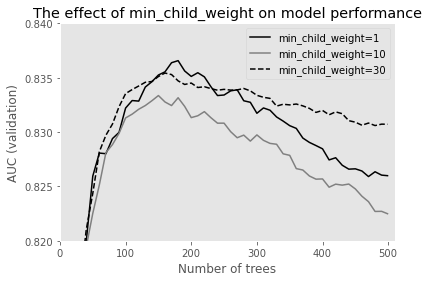

In [71]:
# plotting for comparison
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_mcw1, color='black', linestyle='solid', label='min_child_weight=1')
plt.plot(tree, aucs_val_mcw10, color='grey', linestyle='solid', label='min_child_weight=10')
plt.plot(tree, aucs_val_mcw30, color='black', linestyle='dashed', label='min_child_weight=30')

plt.ylim(0.82, 0.84)
plt.xlim(0, 510)
plt.xticks(range(0, 501, 100))
plt.yticks(np.linspace(0.82, 0.84, 5))

plt.legend()

plt.title('The effect of min_child_weight on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

plt.show()

From the figure, we see that
* For min_child_weight=1, AUC is 83.6%.
* For min_child_weight=10, AUC is 83.3%.
* For min_child_weight=30, AUC is 83.5%.
The difference we observe between these options is not significant, so we’ll leave the default value.

So the final parameters for our model involves, eta= 0.1, max_depth= 3 and min_child_weight=1. The last step we need to do before finishing the model is selecting the optimal number of trees.

In [72]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [73]:
print(output)

[0]	train-auc:0.77424	val-auc:0.73571
[10]	train-auc:0.84733	val-auc:0.78964
[20]	train-auc:0.86359	val-auc:0.80617
[30]	train-auc:0.87855	val-auc:0.81478
[40]	train-auc:0.88701	val-auc:0.81990
[50]	train-auc:0.89458	val-auc:0.82595
[60]	train-auc:0.90159	val-auc:0.82807
[70]	train-auc:0.90650	val-auc:0.82801
[80]	train-auc:0.91110	val-auc:0.82940
[90]	train-auc:0.91428	val-auc:0.82997
[100]	train-auc:0.91801	val-auc:0.83221
[110]	train-auc:0.92205	val-auc:0.83290
[120]	train-auc:0.92460	val-auc:0.83285
[130]	train-auc:0.92843	val-auc:0.83414
[140]	train-auc:0.93100	val-auc:0.83463
[150]	train-auc:0.93296	val-auc:0.83525
[160]	train-auc:0.93551	val-auc:0.83554
[170]	train-auc:0.93788	val-auc:0.83638
[180]	train-auc:0.93971	val-auc:0.83657
[190]	train-auc:0.94203	val-auc:0.83562
[200]	train-auc:0.94334	val-auc:0.83512
[210]	train-auc:0.94501	val-auc:0.83546
[220]	train-auc:0.94693	val-auc:0.83508
[230]	train-auc:0.94839	val-auc:0.83417
[240]	train-auc:0.94999	val-auc:0.83336
[250]	train

In [74]:
# selecting max auc
tree, _, aucs_val = parse_xgb_output(output)
print(max(aucs_val))

0.83657


In [75]:
# optimal trees
max(zip(aucs_val, tree))

(0.83657, 180)

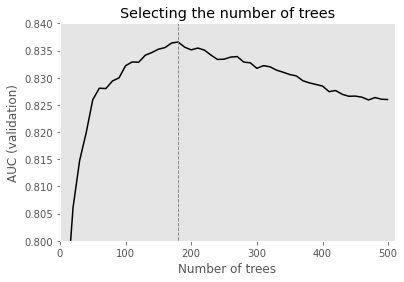

In [76]:
# plot to show peak
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val, color='black', linestyle='solid')


plt.ylim(0.80, 0.84)
plt.xlim(0, 510)
plt.xticks(range(0, 501, 100))
plt.yticks(np.linspace(0.80, 0.84, 9))


plt.vlines(180, 0, 1, color='grey', linestyle='dashed', linewidth=0.9)

plt.title('Selecting the number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

plt.show()

In [77]:
# final model
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=180, verbose_eval=10,
                  evals=watchlist)

[0]	train-auc:0.77424	val-auc:0.73571
[10]	train-auc:0.84733	val-auc:0.78964
[20]	train-auc:0.86359	val-auc:0.80617
[30]	train-auc:0.87855	val-auc:0.81478
[40]	train-auc:0.88701	val-auc:0.81990
[50]	train-auc:0.89458	val-auc:0.82595
[60]	train-auc:0.90159	val-auc:0.82807
[70]	train-auc:0.90650	val-auc:0.82801
[80]	train-auc:0.91110	val-auc:0.82940
[90]	train-auc:0.91428	val-auc:0.82997
[100]	train-auc:0.91801	val-auc:0.83221
[110]	train-auc:0.92205	val-auc:0.83290
[120]	train-auc:0.92460	val-auc:0.83285
[130]	train-auc:0.92843	val-auc:0.83414
[140]	train-auc:0.93100	val-auc:0.83463
[150]	train-auc:0.93296	val-auc:0.83525
[160]	train-auc:0.93551	val-auc:0.83554
[170]	train-auc:0.93788	val-auc:0.83638
[179]	train-auc:0.93962	val-auc:0.83648


In [78]:
y_pred_xgb = model.predict(dval)

roc_auc_score(y_val, y_pred_xgb)

0.8364807100821002

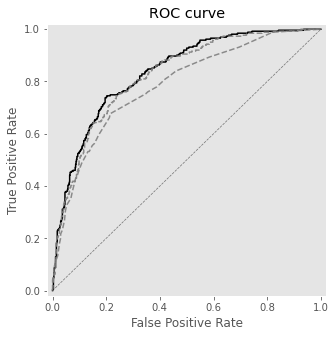

In [79]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred_xgb)
plt.plot(fpr, tpr, color='black')

fpr, tpr, _ = roc_curve(y_val, y_pred_rf)
plt.plot(fpr, tpr, color='grey', linestyle='dashed', alpha=0.9)

fpr, tpr, _ = roc_curve(y_val, y_pred_dt)
plt.plot(fpr, tpr, color='grey', linestyle='dashed', alpha=0.9)

plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

Selecting the optimal tree is quiet easy as we only need to look at the iteration score when the validation score peaked (see figure) and use that number. In this case, we need to train 180 trees for the final model.

The best the random forest model could get was 82.5% AUC, whilst the best gradient boosting could get is 1% more. The ROC curve shows that XGBoost is the better model. This says that XGBoost is our best model and we should use it for scoring the loan applications.

# Testing the final model
Here's what we're going to do. 
* We'll the same preprocessing to *df_full_train* and *df_test* as we did to *df_train* and *df_val*. 
* Train a model on the combine dataset of *df_train* and *df_val*. Withe the same parameters we selected previously. We no longer need the validation dataset, so we can use more data for training, making the model slightly better in the process.
* Apply the model to test data to get the predictions. Then lastly verify the model performs well and doesn't overfit.


In [80]:
# create target variable
y_full_train = (df_full_train.status == 'default').values
y_test = (df_test.status == 'default').values

# remove the target variable from entire Dataframe
del df_full_train['status']
del df_test['status']

We convert DataFrames into lists of dictionaries and then use one-hot encoding to get the feature matrices.

In [81]:
dict_full_train = df_full_train.fillna(0).to_dict(orient='records')
dict_test = df_test.fillna(0).to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dict_full_train)
X_test = dv.transform(dict_test)

In [82]:
# test random forest
rf_final = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=1)
rf_final.fit(X_full_train, y_full_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]

In [83]:
# test XGBoost
dtrain_full = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=dv.feature_names_)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=dv.feature_names_)

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

num_trees = 160

xgb_final = xgb.train(xgb_params, dtrain_full, num_boost_round=num_trees)

In [84]:
y_pred_xgb = xgb_final.predict(dtest)

In [85]:
print(roc_auc_score(y_test, y_pred_rf))
print(roc_auc_score(y_test, y_pred_xgb))

0.8241777039245393
0.8322845901959826


The output is 83.2%, which is comparable to 83.6% — the performance on the validation set. It means that our model doesn’t overfit and can work well with customers it hasn’t seen.

# Conclusion
In this project I went over the basics of using decision trees, random forest, and gradient boosting. We did a lot, and there's way more we can do and learn. One of the things we could do is feature engineering. A process of creating new features out of existing ones. In order to create new features on our project, domain knowledge is needed and more research. On this page https://github.com/gastonstat/CreditScoring/, some features are created, which requires domain expertise to understand and improve the model. Another idea is to use feature selection. We were select the best features that work well and improves the results. In summary, there's still a bit more to do to try and improve the models.

We didn't cover all tree based models. On Scikit-learn there are a handful of other models that we could put our hands on. Models like Extra trees, AdaBoost etc. Tree based models often quite performs well. On searching literature, gradient boosting is well praised and great, and often achieves the best possible performance on structured data.